In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
from acquire_prepare import acquire_oil
from acquire_prepare import prep_data
import numpy as np
import pandas as pd

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import sys # used in command to make entire array print by default

# Feature Selection
import xgboost as xgb
from sklearn.decomposition import PCA

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# makes entire array print by default, 
# can add [:##] to end to set length
np.set_printoptions(threshold=sys.maxsize)

In [4]:
df = acquire_oil()
df = prep_data(df)

# Analyze Data

## Summarize Data

### Data Structure

In [5]:
df.shape

(12523, 36)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12523 entries, 8 to 19495
Data columns (total 36 columns):
api14                 12523 non-null int64
lease_name            12523 non-null object
well_number           12523 non-null object
county                12523 non-null object
type                  12523 non-null category
status                12523 non-null category
oper                  12523 non-null object
multi_well_lease      12523 non-null object
major_phase           12523 non-null category
formation             12512 non-null object
proppant_ppf          9711 non-null float64
prod_method           12523 non-null category
frac_fluid_gpf        11105 non-null float64
lateral_len           12523 non-null float64
frac_stages           11587 non-null float64
frac_fluid_type       12366 non-null category
first_prod            12523 non-null datetime64[ns]
last_prod             12523 non-null datetime64[ns]
oil_gravity           12204 non-null float64
peak_boepd            12523 non

In [7]:
df.sample(3)

,api14,lease_name,well_number,county,type,status,oper,multi_well_lease,major_phase,formation,...,sur_long,well_id,mid_point_lat,mid_point_long,recovery,recovery_per_foot,months_active,recovery_per_month,lateral_class,vintage
3281,42173342730000,BLALOCK F,113,GLASSCOCK,Vertical,Inactive,XTO ENERGY INCORPORATED,False,OIL,FUSSELMAN,...,-101.713272,156544,31.934659,-101.713272,34.223000,3422.300000,19,1801.210526,one,2011
6246,42235353680000,SCOTT SUGG 2726,H 13M,IRION,Horizontal,Active,APACHE CORPORATION,True,OIL,WOLFCAMP,...,-101.076289,143938,31.264138,-101.076458,242.907503,32.058533,58,4188.060394,eight,2014
10652,42329406670000,RAB DAVIDSON 22D,2713K,MIDLAND,Horizontal,Active,ENCANA OIL & GAS (USA) INCORPORATED,True,OIL,WOLFCAMP,...,-102.095960,146452,31.679841,-102.098966,255.185333,31.311084,34,7505.450980,nine,2016


### Data Distributions

In [8]:
print (df.apply(lambda x: x.nunique()))

api14                 12351
lease_name             5763
well_number            4213
county                   52
type                      2
status                    2
oper                    472
multi_well_lease          2
major_phase               3
formation               154
proppant_ppf           9523
prod_method               9
frac_fluid_gpf        10613
lateral_len            5835
frac_stages              65
frac_fluid_type          10
first_prod              601
last_prod               406
oil_gravity             191
peak_boepd            11949
oil_hist              12211
gas_hist              12192
gor_hist              12516
ip90_boeqpd           12228
landing_depth          5397
sur_lat               12028
sur_long              12218
well_id               12523
mid_point_lat         12280
mid_point_long        12295
recovery              12506
recovery_per_foot     12515
months_active           523
recovery_per_month    12420
lateral_class            14
vintage             

In [9]:
df.describe()

,api14,proppant_ppf,frac_fluid_gpf,lateral_len,frac_stages,oil_gravity,peak_boepd,oil_hist,gas_hist,gor_hist,...,sur_lat,sur_long,well_id,mid_point_lat,mid_point_long,recovery,recovery_per_foot,months_active,recovery_per_month,vintage
count,1.252300e+04,9711.000000,11105.000000,12523.000000,11587.000000,12204.000000,12523.000000,12523.000000,12523.000000,12523.000000,...,12523.000000,12523.000000,12523.000000,12523.000000,12523.000000,12523.000000,12523.000000,12523.000000,1.252300e+04,12523.000000
mean,4.222996e+13,1342.497292,1270.473671,4768.668131,2.648658,2.701977,483.629057,127.962449,388.979704,3671.045391,...,31.723877,-102.194086,139754.902979,31.724188,-102.194201,170.103297,262.623092,80.357023,inf,2009.232053
std,9.380980e+11,4008.538057,6262.632605,3150.512301,8.411421,11.204653,466.536676,114.999612,454.379270,3785.667567,...,0.530322,0.851444,19010.808820,0.530217,0.851417,176.216382,2328.416404,94.705842,NaN,10.910190
min,3.000528e+13,1.000000,0.000000,1.000000,0.000000,0.000000,0.071233,0.002000,0.001000,0.020168,...,30.447167,-104.359908,22866.000000,30.447167,-104.360243,0.000000,0.000000,0.000000,0.000000e+00,1955.000000
25%,4.221934e+13,512.766116,235.793579,1578.000000,0.000000,0.000000,101.589596,40.475500,79.340000,1270.117060,...,31.361323,-102.801819,142255.500000,31.363456,-102.802620,50.436083,15.904779,33.000000,6.948475e+02,2009.000000
50%,4.232934e+13,1167.159420,1063.788450,4587.000000,0.000000,0.000000,383.739075,102.894000,256.800000,2325.685550,...,31.657858,-101.955182,146368.000000,31.658005,-101.955600,126.466014,27.939733,52.000000,2.368416e+03,2014.000000
75%,4.238340e+13,1608.079770,1609.000000,7383.000000,0.000000,0.000000,727.376587,183.316000,530.014000,4621.494250,...,31.975325,-101.538640,150752.500000,31.978206,-101.538778,211.323089,57.854686,77.000000,4.786894e+03,2015.000000
max,4.250137e+13,146969.000000,424824.750000,13815.000000,70.000000,68.000000,9358.215000,1659.710000,4692.163000,19977.940000,...,33.834820,-100.689460,157521.000000,33.836550,-100.691821,999.305470,108604.047619,747.000000,inf,2018.000000


In [10]:
len(df.columns) # 36 features

36

## Standardize Numeric Data

In [11]:
numerics = ['int64', 'float64']

num_df = df.select_dtypes(include=numerics)
num_df.columns

Index(['api14', 'proppant_ppf', 'frac_fluid_gpf', 'lateral_len', 'frac_stages',
       'oil_gravity', 'peak_boepd', 'oil_hist', 'gas_hist', 'gor_hist',
       'ip90_boeqpd', 'landing_depth', 'sur_lat', 'sur_long', 'well_id',
       'mid_point_lat', 'mid_point_long', 'recovery', 'recovery_per_foot',
       'months_active', 'recovery_per_month', 'vintage'],
      dtype='object')

In [12]:
num_df = num_df.drop(columns=['gas_hist', 'recovery', 'recovery_per_foot', 
                              'recovery_per_month', 'landing_depth', 'api14',
                             'sur_long', 'sur_lat', 'mid_point_lat', 'mid_point_long',
                             'well_id', 'oil_hist'])
num_df.columns

Index(['proppant_ppf', 'frac_fluid_gpf', 'lateral_len', 'frac_stages',
       'oil_gravity', 'peak_boepd', 'gor_hist', 'ip90_boeqpd', 'months_active',
       'vintage'],
      dtype='object')

In [13]:
scaled_df = num_df.copy()
scaled_df['proppant_ppf'] = (scaled_df.proppant_ppf - scaled_df.proppant_ppf.min()) / (scaled_df.proppant_ppf.max() - scaled_df.proppant_ppf.min())
scaled_df['frac_fluid_gpf'] = (scaled_df.frac_fluid_gpf - scaled_df.frac_fluid_gpf.min()) / (scaled_df.frac_fluid_gpf.max() - scaled_df.frac_fluid_gpf.min())
scaled_df['lateral_len'] = (scaled_df.lateral_len - scaled_df.lateral_len.min()) / (scaled_df.lateral_len.max() - scaled_df.lateral_len.min())
scaled_df['frac_stages'] = (scaled_df.frac_stages - scaled_df.frac_stages.min()) / (scaled_df.frac_stages.max() - scaled_df.frac_stages.min())
scaled_df['oil_gravity'] = (scaled_df.oil_gravity - scaled_df.oil_gravity.min()) / (scaled_df.oil_gravity.max() - scaled_df.oil_gravity.min())
scaled_df['peak_boepd'] = (scaled_df.peak_boepd - scaled_df.peak_boepd.min()) / (scaled_df.peak_boepd.max() - scaled_df.peak_boepd.min())
#scaled_df['oil_hist'] = (scaled_df.oil_hist - scaled_df.oil_hist.min()) / (scaled_df.oil_hist.max() - scaled_df.oil_hist.min())
scaled_df['gor_hist'] = (scaled_df.gor_hist - scaled_df.gor_hist.min()) / (scaled_df.gor_hist.max() - scaled_df.gor_hist.min())
scaled_df['ip90_boeqpd'] = (scaled_df.ip90_boeqpd - scaled_df.ip90_boeqpd.min()) / (scaled_df.ip90_boeqpd.max() - scaled_df.ip90_boeqpd.min())
scaled_df['months_active'] = (scaled_df.months_active - scaled_df.months_active.min()) / (scaled_df.months_active.max() - scaled_df.months_active.min())
scaled_df['vintage'] = (scaled_df.vintage - scaled_df.vintage.min()) / (scaled_df.vintage.max() - scaled_df.vintage.min())
scaled_df.head()

,proppant_ppf,frac_fluid_gpf,lateral_len,frac_stages,oil_gravity,peak_boepd,gor_hist,ip90_boeqpd,months_active,vintage
8,0.001446,0.000023,0.360649,0.000000,NaN,0.019635,0.071030,0.022445,0.128514,0.888889
9,0.001716,0.000655,0.376140,0.142857,NaN,0.028360,0.080742,0.016353,0.144578,0.873016
10,0.002262,0.000754,0.343420,0.000000,NaN,0.018393,0.087298,0.024103,0.132530,0.873016
11,0.007045,0.002107,0.280151,0.000000,NaN,0.003524,0.032044,0.003225,0.124498,0.873016
12,0.002684,0.000738,0.273780,0.157143,NaN,0.040909,0.065694,0.074228,0.145917,0.873016


In [14]:
xgb_df = scaled_df.copy()

## Visualize Data

### Attribute Histograms

#### XGBoost Feature Recommender

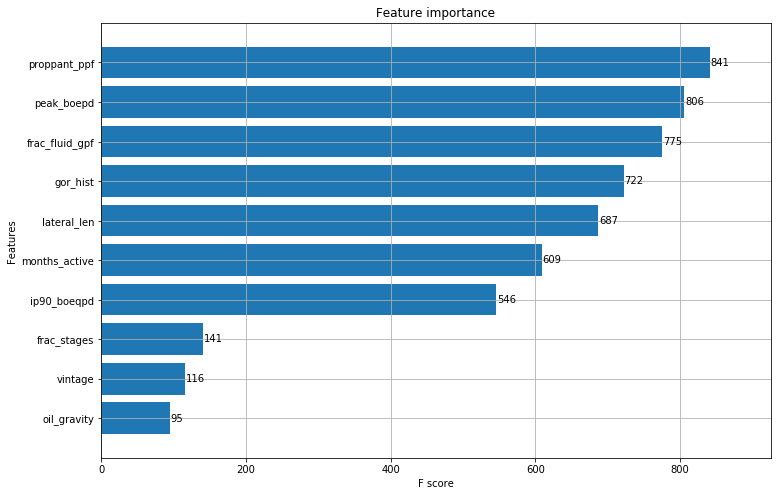

In [15]:
xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, df.oil_hist, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

####  PCA (Principal Component Analysis) Feature Recommender

### Pairwise Scatterplots of Attributes